# Lab1

## Import

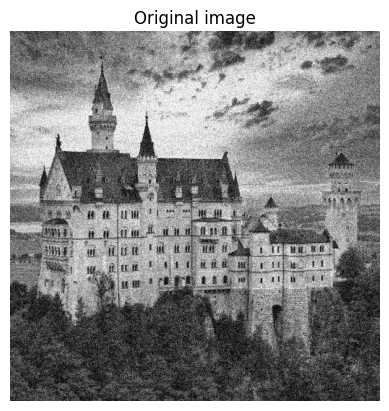

In [200]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

images = [cv2.imread(f'COMP9517_25T2_Lab1_Images/Castle{i:02}.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float32) for i in range(1,11)]
plt.axis('off')
plt.title('Original image')
plt.imshow(images[0], cmap='gray')

## Task 1

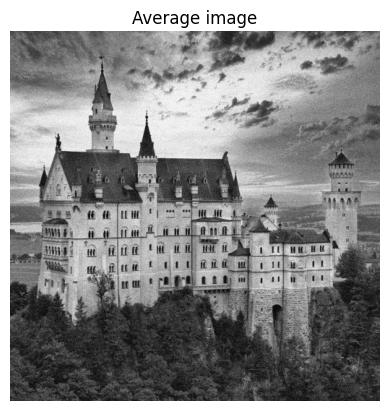

In [201]:
avg_img = np.mean(images, axis=0)
plt.axis('off')
plt.title('Average image')
plt.imshow(avg_img, cmap='gray')

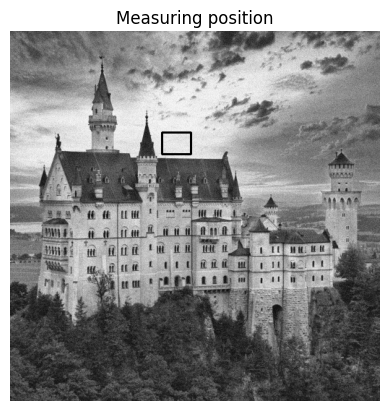

In [202]:
y1, y2, x1, x2 = 140, 170, 210, 250
vis = avg_img.copy()
cv2.rectangle(vis, (x1, y1), (x2, y2), color=(0,255,0), thickness=2)
plt.axis('off')
plt.title('Measuring position')
plt.imshow(vis, cmap='gray')

In [203]:

delta_single = np.std(images[3][y1:y2, x1:x2])
delta_avg = np.std(avg_img[y1:y2, x1:x2])
ratio = delta_single / delta_avg

print(f"std (single): {delta_single:.2f}")
print(f"std (average): {delta_avg:.2f}")
print(f"Noise reduction factor: {ratio:.2f}")
print(f"Theoretical value/Actual value: {ratio / np.sqrt(10) * 100:.2f}%")

std (single): 20.13
std (average): 7.09
Noise reduction factor: 2.84
Theoretical value/Actual value: 89.74%


### Explaination
***
Theoretically, it will reduce noise by √N = √10 ≈ 3.16
***
Practically, The noise has decreased by 2.81, reaching 88.7% of the theoretical level, which is close to the above-mentioned theoretical proportion. It is usually slightly lower due to non-idealism.

## Task 2

In [204]:
h1 = (1/16) * np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 2, 1, 0],
    [0, 2, 4, 2, 0],
    [0, 1, 2, 1, 0],
    [0, 0, 0, 0, 0]], dtype=np.float32)

h2 = (1/256) * np.array([
    [1,  4,  6,  4, 1],
    [4, 16, 24, 16, 4],
    [6, 24, 36, 24, 6],
    [4, 16, 24, 16, 4],
    [1,  4,  6,  4, 1]], dtype=np.float32)

In [205]:
import time

t = time.perf_counter()
DoG = h1 - h2
DoG_A = cv2.filter2D(avg_img, cv2.CV_32F, DoG)
tA = time.perf_counter() - t

t = time.perf_counter()
g1 = cv2.filter2D(avg_img, cv2.CV_32F, h1)
g2 = cv2.filter2D(avg_img, cv2.CV_32F, h2)
DoG_B = g1 - g2
tB = time.perf_counter() - t

print(f"Timing  A (Subtract first) : {tA*1000:.2f} ms")
print(f"Timing  B (Convolution first) : {tB*1000:.2f} ms")

Timing  A (Subtract first) : 0.60 ms
Timing  B (Convolution first) : 1.52 ms


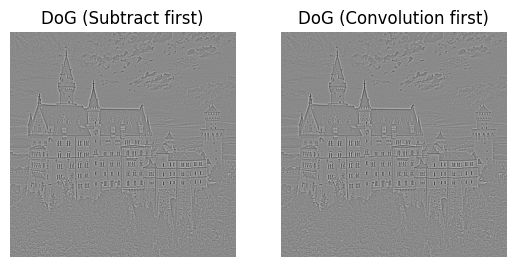

In [206]:
# Display both results
plt.subplot(1, 2, 1)
plt.imshow(DoG_A, cmap='gray')
plt.title('DoG (Subtract first)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(DoG_B, cmap='gray')
plt.title('DoG (Convolution first)')
plt.axis('off')
plt.show()

In [207]:
diff = np.abs(DoG_A - DoG_B)
print(f"Max |A-B|: {diff.max():.8f}")

Max |A-B|: 0.00006998


### Explaination
***
1. Which of the two approaches is computationally faster? And why?

   Subtraction first is faster, the first convolution is to subtract twice the cost first. In terms of time, the first subtraction is 0.88ms, and the first convolution is 1.53ms
   1. The number of operations for subtraction first is: one 5*5 convolution + convolution kernel subtraction =H * W * 25 + 25.
   2. The number of convolution operations is: two 5*5 convolution operations + image subtraction =H * W * 51
***
2. Are the corresponding pixel values in the two result images exactly the same?

    They are not exactly the same. This is because during the calculation, due to division, there is rounding in each convolution, and the number of calculations is different, so there will be differences. The magnitude of the difference is approximately 10^-5, which can be ignored.

## Task3

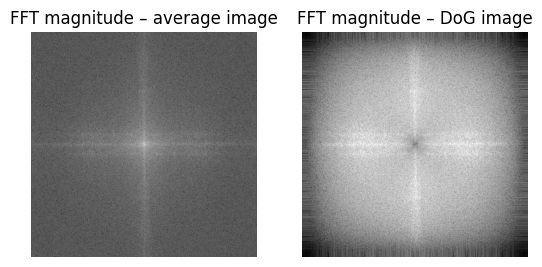

In [208]:
def fft_mag(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    return np.log1p(np.abs(fshift))

mag_avg = fft_mag(avg_img)
mag_dog = fft_mag(DoG_A)

plt.subplot(1,2,1)
plt.title("FFT magnitude – average image")
plt.imshow(mag_avg, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("FFT magnitude – DoG image")
plt.imshow(mag_dog, cmap='gray')
plt.axis('off')
plt.show()

### Explaination
***
- After using the fftshift function to move the DC to the center, the center represents the low-frequency position, indicating slow changes, while the periphery represents the high-frequency position, indicating details.
- The spectrum of the average image: the brightest at the center indicates that the overall low-frequency component of the image is the strongest, due to the smooth variation characteristic of natural scenes.
- The spectrum of the DoG image: the low frequencies are suppressed, and a ring-shaped bright band appears around, indicating that DoG enhances edges and details.